# Example 2.3: Auto and cross-correlation from time series 

In this example, we will calculate correlation functions from time series (realizations) of stochastic processes. We will first consider auto correlation and then the cross-correlation matrix.

The stochastic processes under consideration are wave elevations taken from three wave radar sensors: $w_1(t)$, $w_2(t)$, and $w_3(t)$. These sensors are placed at an inter distance of approx. 1 and 2 meters, as shown in the figure. By intuition, we can expect that the wave elevations at these three locations are correlated but not perfectly identical. This information should be contained within the cross-correlation. We also expect that the wave frequencies are contained in the auto correlation.

<center>
<img src="figures\Wave_measurement.svg"  width="500" >
</center>

## First look at data and basic statistics

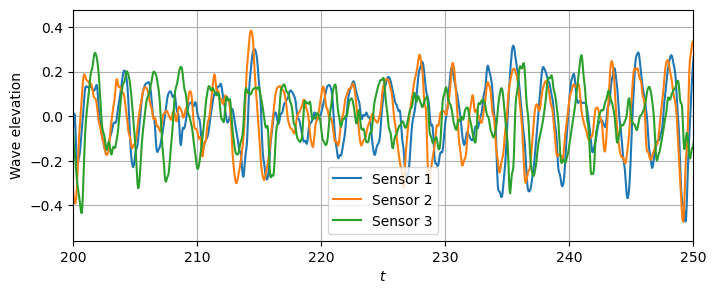

In [36]:
# Import and plot time series

import numpy as np
from matplotlib import pyplot as plt

# Load data from text file
data=np.loadtxt('data/wave_timeseries.txt',delimiter=',',skiprows=1).T

t=data[0,:] # Time vector
x=data[1:,:] # Matrix with 3 wave elevation time series

dt=t[2]-t[1]

plt.figure(figsize=(8,3))
plt.plot(t,x[0,:],label='Sensor 1')
plt.plot(t,x[1,:],label='Sensor 2')
plt.plot(t,x[2,:],label='Sensor 3')
plt.xlabel("$t$")
plt.ylabel("Wave elevation")
plt.xlim(200,250)
plt.legend()
plt.grid()


Before calculating auto correlations, let's check the basic statistics of the time series.

In [23]:
# Mean and standard deviation
x_mean=np.mean(x,axis=1)
x_sigma=np.std(x,axis=1)

print('Mean:' + str(x_mean))
print('Standard deviation:' + str(x_sigma))

Mean:[-1.83433611e-05  3.35439167e-05  3.95640833e-05]
Standard deviation:[0.112031   0.1118747  0.10920003]


As expected, the mean value is practically zero. The waves have crests and troughs (peaks and valleys), but averaged over time the mean value equals the still ocean surface. The standard deviations are approx. 11 cm. It is reasonable that all measurements have equal statistics since the sensors measure the same wave field, even though their time series are different.


## Part 1: Auto correlation

We will now calculate the auto-correlation from the time series. Formally, the auto correlation is defined as:
$$
R(\tau)=
\text{E}\left[ x(t) x(t+\tau) \right]
$$
If the process is ergodic, we can find it from a single time series as: 
$$
R(\tau)=
\dfrac{1}{T}
\int_0^T x(t)x(t+\tau) \: \text{d} t
\quad
( T \rightarrow \infty)
$$

We are dealing with a discretely measured signal (vector with numbers):

$$
\mathbf{x}=
\left[x(t_0) \:,\: x(t_1) \:,\: x(t_2) \:,\: x(t_3) \:,\: \dots \right]
$$

The integral therefore becomes a sum:

$$
R(\tau)=R(\tau=n\cdot \Delta t)
=
\dfrac{1}{N-|n|}
\sum_{k=0}^{N-|n|-1}
x(t_k) x(t_k+\tau)
$$
The vector with the time lags becomes:
$$
\tau=
\left[
\dots \:,\: -3 \Delta t \:,\: -2 \Delta t \:,\: -\Delta t \:,\: 0 \:,\: \Delta t \:,\: 2\Delta t \:,\: 3\Delta t \:,\: \dots \right]
$$

The summation is implemented in python in the functions *np.correlate()* or *scipy.signal.correlate()*.


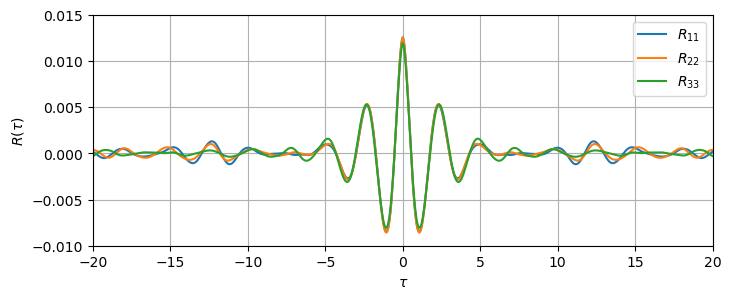

In [35]:

N=np.shape(x)[1] # Length of data
lags = np.arange(-N + 1, N) # Vector with all lags
tau=lags*dt # Vector with all lags in seconds

# Calculate auto correlation
R1 = np.correlate(x[0,:],x[0,:], mode='full') / (N - np.abs(lags))
R2 = np.correlate(x[1,:],x[1,:], mode='full') / (N - np.abs(lags))
R3 = np.correlate(x[2,:],x[2,:], mode='full') / (N - np.abs(lags))

# Plot the ACF
plt.figure(figsize=(8, 3))
plt.plot(tau, R1,label='$R_{11}$')
plt.plot(tau, R2,label='$R_{22}$')
plt.plot(tau, R3,label='$R_{33}$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$R(\tau)$')
plt.xlim(-20,20)
plt.ylim(-10e-3,15e-3)
plt.grid(True)
plt.legend()


Observations:

* Symmetry around the vertical axis.

* Maximum at $\tau=0$. We can confirm that the value is the variance, $R(\tau=0)=\sigma^2$.

* Decay to zero for large $\tau$. There is no practically no correlation after $\tau=\pm 5$ s. However, since we are dealing with measurement data of finite length and some measurement noise, $R(\tau)$ will never fully reach zero. We can consider the content beyond $\pm 5$ s as noise tails.

* In addition to the peak at $\tau=0$, there are peaks at $\tau\approx 2.5$ s and $\tau\approx 5$ s. This periodicity indicates that the waves are a  process with dominant frequency content around $f_w=\dfrac{1}{T_w}=\dfrac{1}{2.5}=0.4$ Hz.

## Part two: Cross-correlation

Now, let's consider the cross-correlation between all three wave elevations. The cross-correlation is defined as:
$$
R_{X_1 X_2}(\tau)=
\text{E}\left[ x_1(t) x_2(t+\tau) \right]
$$
By repeating the previous arguments, the cross-correlation can be calculated from the time series as follows:
$$
R_{X_1 X_2}(\tau)
=
\dfrac{1}{N-|n|}
\sum_{k=0}^{N-|n|-1}
x_1(t_k) x_2(t_k+\tau)
$$

We can still use the same correlation function from *numpy*. All combinations of the three signals can be assembled in the cross-correlation matrix:

$$
\mathbf{R}_\mathbf{x}=
 \left[ 
{\begin{array}{ccc}
R_{X_1 X_1}(\tau) & R_{X_1 X_2}(\tau) & R_{X_1 X_3}(\tau) \\
R_{X_2 X_1}(\tau) & R_{X_2 X_2}(\tau) & R_{X_2 X_3}(\tau) \\
R_{X_3 X_1}(\tau) & R_{X_3 X_2}(\tau) & R_{X_3 X_3}(\tau) 
\end{array}}
\right]
$$




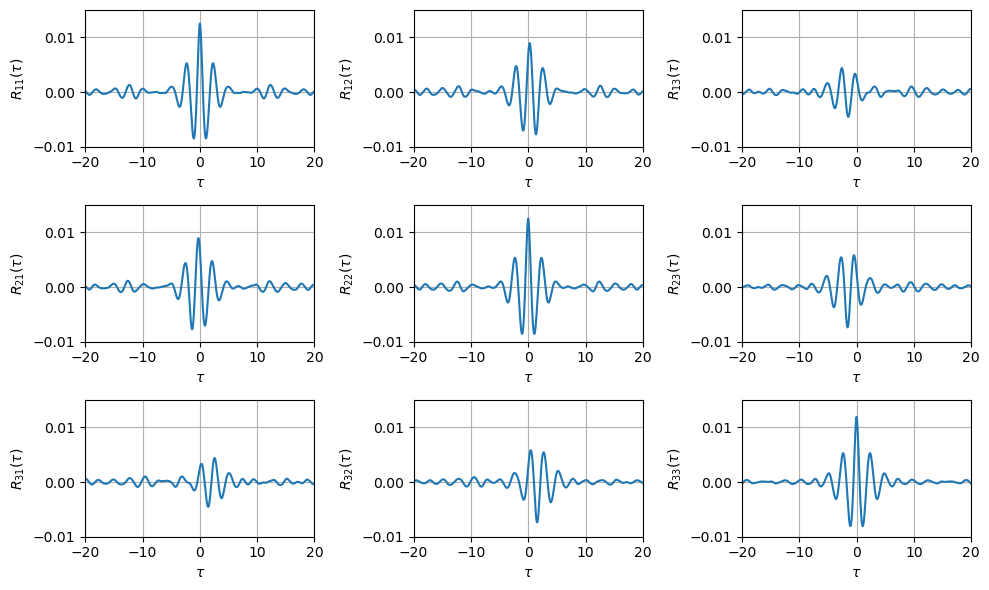

In [30]:
# Allocate empty cross-correlation matrix
Rx=np.zeros((3,3,2*N-1))

# Loop over all 3*3 combinations of correlations
for i in np.arange(3):
    for j in np.arange(3):
        Rx[i,j,:] = np.correlate(x[i,:],x[j,:], mode='full') / (N - np.abs(lags))

# Plot
fig, axs = plt.subplots(3, 3,figsize=(10, 6))

for i in np.arange(3):
    for j in np.arange(3):
        axs[i,j].plot(tau, Rx[i,j,:]) # Auto and cross correlation - regular
        #axs[i,j].plot(tau, Rx[i,j,:]/w_sigma[i]/w_sigma[j]) # Auto and cross correlation - normalized
        axs[i,j].set_xlabel(r'$\tau$')
        axs[i,j].set_ylabel(r'$R_{' + str(i+1) +  str(j+1) + '} (\\tau)$')
        axs[i,j].set_xlim(-20,20)
        axs[i,j].set_ylim(-10e-3,15e-3)
        #axs[i,j].set_ylim(-1,1)
        axs[i,j].grid(True)

plt.tight_layout()

Observations:

* The diagonal elements represent the auto correlations, maintaining the properties previously discussed.

* The cross-correlations in the off-diagonal elements show that there is a non-zero correlation between the three signals.

* The cross-correlations show their highest peak at $\tau \neq 0$, which implies the presence of a time delay between the signals. This phenomenon can  be explained by the fact that the wave typically passes one sensor before reaching another sensor 1-2 seconds later, depending on the wave's propagation direction relative to the sensor placement.
  
* All correlation functions decay towards zero eventually.


## The importance of the joint distribution of all loads

Imagine that there was a marine structure with three legs where sensors are located. The joint distribution of wave loading on these three legs would play an important role for the dynamic loading and response of the structure. The cross-correlation between the wave signals provides insight into how the wave loading would be correlated in time and space.

Often, the most critical scenario for the dynamic response is when multiple forces reach their maximum simultaneously: this would correspond to a positive peak at $\tau=0$ for all elements in $\mathbf{R}_\mathbf{x}(\tau)$. There can also be cases where a delay between the forces is more critical. This will depend on the specific structure, its natural frequencies compared to the load frequency, and the mode shapes.





